# Table of contents
1. [Initial Cleaning](#section-1)
2. [Normalizing Shark Species Information](#section-2)
3. [Shark Lethality](#section-3)

In [1]:
# Libraries Import Section:

In [2]:
# Library import
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
# Saving images
""""
sharks_fatal4_graph.figure.savefig("./images/lethality.png", dpi=1000)
sharks_aggre3_graph.figure.savefig("./images/aggresivity.png", dpi=1000)
species_count.figure.savefig("./images/shark-species.png", dpi=1000)
"""

In [3]:
sharks = pd.read_csv("./data/sharks.csv", encoding='unicode_escape')

# Initial Cleaning<a name="section-1"></a>

- Remove blank lines and duplicates
- Remove columns without useful information for the study

### Initial Database Size:

In [4]:
print(f"""Rows: {sharks.shape[0]}
Columns: {sharks.shape[1]}""")

Rows: 25723
Columns: 24


In [5]:
sharks.dropna(how="all", inplace=True)

In [6]:
sharks = sharks.drop_duplicates()

In [7]:
sharks_species = sharks.drop(['Investigator or Source','pdf','href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23'], axis=1)

### Database Size After Cleaning:

In [8]:
print(f"""Rows: {sharks_species.shape[0]}
Columns: {sharks_species.shape[1]}""")

Rows: 6311
Columns: 15


# Normalizing Shark Species Information:<a name="section-2"></a>
- Add Unknown Shark to all cases without information
- Find if Shark Species are metioned in the cases where something is reported
- Clean and standrize Shark Species reported
- Find the 8 species most reported and group the others in a Other Sharks category

### Defining functions:

In [9]:
def species_clean(string):
    '''
    function to clean species column from database https://www.kaggle.com/datasets/teajay/global-shark-attacks
        1) If no value return "unknown shark"
        2) Set all text to lower case
        3) Using regex finds pattern of word 'shark' precided by one or two words, if can find convert to "unknown shark"
        4) Remove "small" string and "a " string
        5) Remove leading and trailing spaces
        6) If "unidentified" return "unknown shark"
        7) Return either shark species or "unknown shark"
        
    '''
    if not isinstance(string, str):
        return "unknown shark"
    string = string.lower()
    if re.match("[A-Za-z]+\s?[A-Za-z]{3,}\ssharks?", string):
        shark = re.match("[A-Za-z]+\s?[A-Za-z]{3,}\ssharks?", string)[0]
        if "small" in shark:
            shark = shark.replace("small", "")
        if "a " in shark:
            shark = shark.replace("a ", "")
        elif "uidentified" in shark:
            return 'unknown shark'
        shark = shark.strip()
        if shark == "shark":
            return 'unknown shark'
        else: 
            return shark
    else:
        return 'unknown shark'
def substrings_cleaning(list):
    '''
    Removes substrings from a strings list
    '''
    clean_list = list.copy()
    is_sub = False
    for e in list:
        for i in range(0,len(list)):
            if e in list[i] and list[i] in clean_list and e != list[i]:
                clean_list.remove(list[i])
    return clean_list
def clean_categories(element, categories_list):
    '''
    function to clean subcategories (contains any category as a substring) from a categories list
    '''
    if element in categories_list:
            return element
    else:
        for e in categories_list:
            if element in e:
                return e
                break
        

### Extracting Shark Species:

In [10]:
sharks_species["Species "] = sharks_species["Species "].apply(species_clean)

### Groupping Species:

In [11]:
species_list = substrings_cleaning(list(sharks_species["Species "].unique()))
sharks_species["Species "] = sharks_species["Species "].apply(lambda x: clean_categories(x, species_list))

### Keep the 8 species with more incidents and group the rest as "Other Sharks"

In [12]:
top_8 = list(sharks_species["Species "].value_counts().index)[:10]
sharks_species["Species "] = sharks_species["Species "].apply(lambda x: x.title() if x in top_8 else "Other Sharks" )

## Adding a new column "Shark Identified"

In [13]:
sharks_species["Shark Identified"] = sharks_species["Species "].apply(lambda x: 0 if x == 'Unknown Shark' else 1)

### Result:

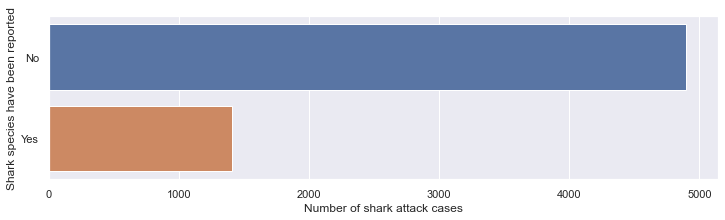

In [14]:
sns.set(rc={"figure.figsize": (12.,3.)})
identified_shark = sns.countplot(y="Shark Identified", data=sharks_species)
identified_shark.set_yticklabels(labels=["No", "Yes"])
identified_shark.set(xlabel="Number of shark attack cases", ylabel="Shark species have been reported")
plt.show()

In [15]:
sharks_species["Species "].value_counts()

Unknown Shark        4900
White Shark           429
Other Sharks          372
Tiger Shark           231
Bull Shark            128
Nurse Shark            52
Wobbegong Shark        45
Mako Shark             44
Raggedtooth Shark      42
Blacktip Shark         37
Lemon Shark            31
Name: Species , dtype: int64

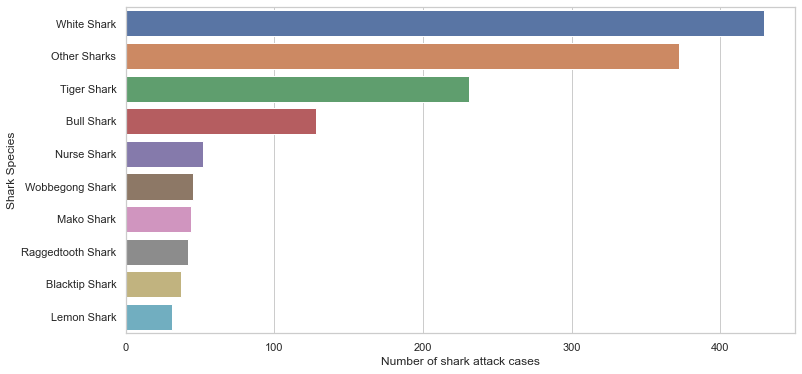

In [16]:
sharks_species_clean = sharks_species[sharks_species["Species "] != "Unknown Shark"]
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12.,6.)})
sns.set_style("whitegrid")
species_count = sns.countplot(y="Species ", data=sharks_species_clean, order = sharks_species_clean['Species '].value_counts().index)
species_count.set(xlabel="Number of shark attack cases", ylabel="Shark Species")
plt.show()

# Checking data biase using sex of the vicitim information 

In [ ]:
## Cleaning Sex column in the dataframe

In [44]:
sharks_sex = sharks_species.copy()
sharks_sex = sharks_sex.dropna(subset=["Sex "])
sharks_sex["Sex "] = sharks_sex["Sex "].apply(lambda x: x.strip())
sharks_sex["Sex "] = sharks_sex["Sex "].apply(lambda x: x if x == "M" or x == "F" else None)
sharks_sex = sharks_sex.dropna(subset=["Sex "])

M    5096
F     637
Name: Sex , dtype: int64

,Shark Identified,Sex,Percentage
0,0,M,88.863892
1,0,F,11.136108
2,1,M,88.975155
3,1,F,11.024845


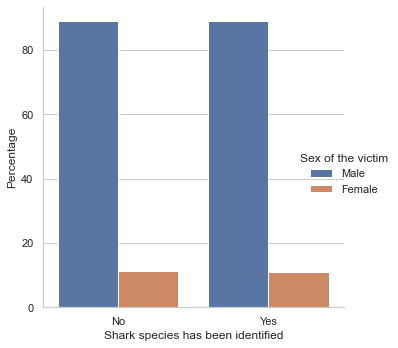

In [54]:
sharks_sex2 = sharks_sex.groupby("Shark Identified")["Sex "] ##grouping
sharks_sex2 = sharks_sex2.value_counts(normalize=True).mul(100) ##Getting the percentage
sharks_sex2 = sharks_sex2.rename("Percentage").reset_index()
sharks_sex2_graph =  sns.catplot(x="Shark Identified", y="Percentage", hue="Sex ", kind='bar', data=sharks_sex2)
sharks_sex2_graph.set(xlabel='Shark species has been identified', ylabel='Percentage')
sharks_sex2_graph.set_xticklabels(labels=["No", "Yes"])
sharks_sex2_graph._legend.set_title("Sex of the victim")
for t, l in zip(sharks_sex2_graph._legend.texts, ["Male", "Female"]):
    t.set_text(l)

# Shark lethality <a name="section-2"></a>

## Defining cleaning fuctions

In [17]:
def fatal_clean(string):
    if not isinstance(string, str):
        return None
    string = string.upper()
    string = string.strip()
    if string == "Y" or string ==  "N":
        return string
    else:
        return None
    

## Standarizing and Cleaning Database for Fatal (Y/N) column

In [18]:
sharks_species["Fatal (Y/N)"] = sharks_species["Fatal (Y/N)"].apply(fatal_clean)
sharks_fatal = sharks_species.dropna(subset=["Fatal (Y/N)"])

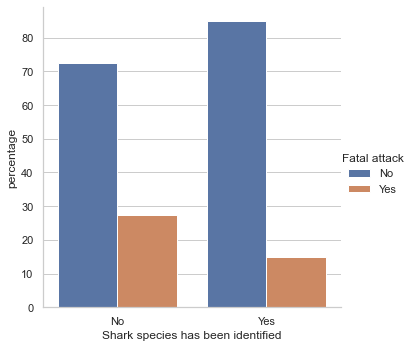

In [19]:
sharks_fatal2 = sharks_fatal.groupby("Shark Identified")["Fatal (Y/N)"] ##grouping
sharks_fatal2 = sharks_fatal2.value_counts(normalize=True).mul(100) ##Getting the percentage
sharks_fatal2 = sharks_fatal2.rename("Percentage").reset_index()
sharks_fatal2_graph =  sns.catplot(x="Shark Identified", y="Percentage", hue="Fatal (Y/N)", kind='bar', data=sharks_fatal2)
sharks_fatal2_graph.set(xlabel='Shark species has been identified', ylabel='percentage', label="Fatal attack")
sharks_fatal2_graph.set_xticklabels(labels=["No", "Yes"])
sharks_fatal2_graph._legend.set_title("Fatal attack")
for t, l in zip(sharks_fatal2_graph._legend.texts, ["No", "Yes"]):
    t.set_text(l)

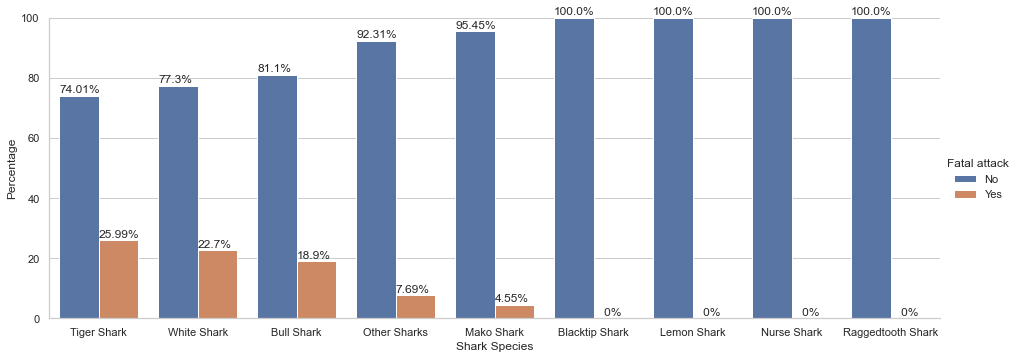

In [87]:
sharks_fatal3 = sharks_fatal[sharks_fatal["Species "] != "Unknown Shark"]
sharks_fatal3 = sharks_fatal.groupby("Species ")["Fatal (Y/N)"] ##grouping
sharks_fatal3 = sharks_fatal3.value_counts(normalize=True).mul(100) ##Getting the percentage
sharks_fatal3 = sharks_fatal3.rename("Percentage").reset_index()
sharks_fatal3_graph =  sns.catplot(x="Species ", y="Percentage", hue="Fatal (Y/N)", kind='bar', aspect=16/6, order=['Tiger Shark','White Shark','Bull Shark', 'Other Sharks', 'Mako Shark', "Blacktip Shark", "Lemon Shark", "Nurse Shark", "Raggedtooth Shark"], data=sharks_fatal3)
sharks_fatal3_graph.set(xlabel='Shark Species', ylabel='Percentage', label="Fatal attack")
sharks_fatal3_graph._legend.set_title("Fatal attack")
for t, l in zip(sharks_fatal3_graph._legend.texts, ["No", "Yes"]):
    t.set_text(l)
sharks_fatal3_graph.ax.set_ylim(0,100)
for p in sharks_fatal3_graph.ax.patches:
    x = p.get_x()
    y = p.get_height()
    if not y > 0:
        y = 0
        txt = '   0%'
    else:
        txt = str(p.get_height().round(2)) + '%'
    sharks_fatal3_graph.ax.text(x,y+1,txt)

## Normalizing data for biase in the data when shark species were reported

In [29]:
no_fatal_norm = sharks_fatal2["Percentage"][0]/sharks_fatal2["Percentage"][2]
fatal_norm = sharks_fatal2["Percentage"][1] /sharks_fatal2["Percentage"][3]
sharks_fatal4 = sharks_fatal3.copy() 
sharks_fatal4['Percentage'] = sharks_fatal4['Percentage'].mask((sharks_fatal4['Percentage'] < 100) & (sharks_fatal4['Percentage'] > 0) & (sharks_fatal4["Fatal (Y/N)"]=="N"), other=sharks_fatal4['Percentage']*no_fatal_norm, axis=0)
sharks_fatal4['Percentage'] = sharks_fatal4['Percentage'].mask((sharks_fatal4['Percentage'] < 100) & (sharks_fatal4['Percentage'] > 0) & (sharks_fatal4["Fatal (Y/N)"]=="Y"), other=sharks_fatal4['Percentage']*fatal_norm, axis=0)


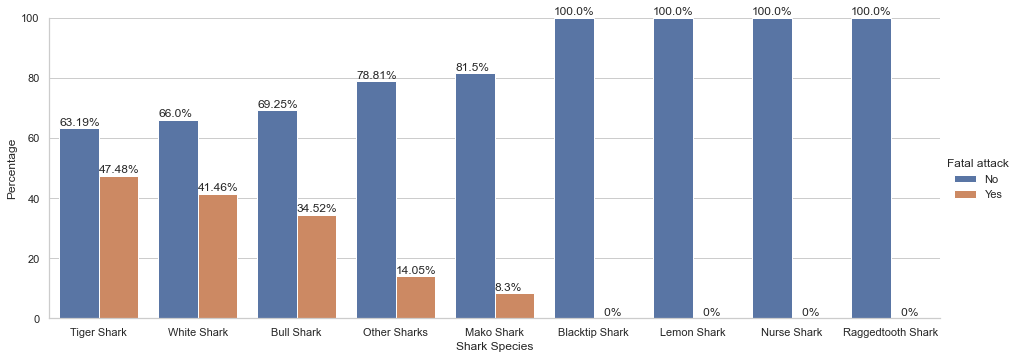

In [89]:
sharks_fatal4_graph =  sns.catplot(x="Species ", y="Percentage", hue="Fatal (Y/N)", kind='bar', aspect=16/6, order=['Tiger Shark','White Shark','Bull Shark', 'Other Sharks', 'Mako Shark', "Blacktip Shark", "Lemon Shark", "Nurse Shark", "Raggedtooth Shark"], data=sharks_fatal4)
sharks_fatal4_graph.set(xlabel='Shark Species', ylabel='Percentage', label="Fatal attack")
sharks_fatal4_graph._legend.set_title("Fatal attack")
for t, l in zip(sharks_fatal4_graph._legend.texts, ["No", "Yes"]):
    t.set_text(l)
sharks_fatal4_graph.ax.set_ylim(0,100)
for p in sharks_fatal4_graph.ax.patches:
    x = p.get_x()
    y = p.get_height()
    if not y > 0:
        y = 0
        txt = '   0%'
    else:
        txt = str(p.get_height().round(2)) + '%'
    sharks_fatal4_graph.ax.text(x,y+1,txt)
sharks_fatal4_graph.figure.savefig("../images/lethality.png", dpi=1000)

# Shark Aggressivity

## Cleaning database only for Unprovoked and Provoked incidents

In [61]:
sharks_aggre = sharks_species[(sharks_species["Type"]=="Unprovoked") | (sharks_species["Type"]=="Provoked")]

## Testing biase for incidents where the shark species was identified

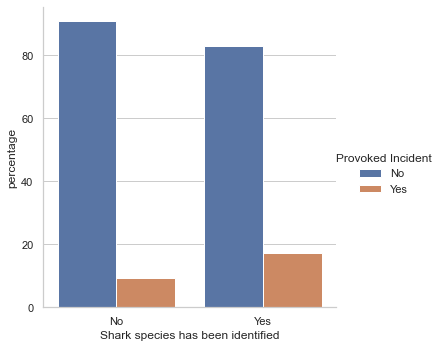

In [65]:
sharks_aggre2 = sharks_aggre.groupby("Shark Identified")["Type"] ##grouping
sharks_aggre2 = sharks_aggre2.value_counts(normalize=True).mul(100) ##Getting the percentage
sharks_aggre2 = sharks_aggre2.rename("Percentage").reset_index()
sharks_aggre2_graph =  sns.catplot(x="Shark Identified", y="Percentage", hue="Type", kind='bar', data=sharks_aggre2)
sharks_aggre2_graph.set(xlabel='Shark species has been identified', ylabel='percentage', label="Fatal attack")
sharks_aggre2_graph.set_xticklabels(labels=["No", "Yes"])
sharks_aggre2_graph._legend.set_title("Provoked Incident")
for t, l in zip(sharks_aggre2_graph._legend.texts, ["No", "Yes"]):
    t.set_text(l)

## Testing aggresivity of each species

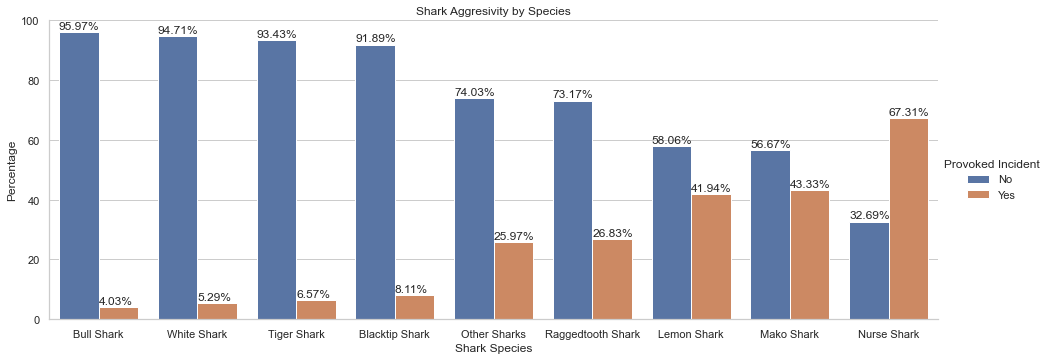

In [69]:
sharks_aggre3 = sharks_aggre[sharks_aggre["Species "] != "Unknown Shark"]
sharks_aggre3 = sharks_aggre.groupby("Species ")["Type"] ##grouping
sharks_aggre3 = sharks_aggre3.value_counts(normalize=True).mul(100) ##Getting the percentage
sharks_aggre3 = sharks_aggre3.rename("Percentage").reset_index()
sharks_aggre3_graph =  sns.catplot(x="Species ", y="Percentage", hue="Type", kind='bar', aspect=16/6, order=["Bull Shark", "White Shark", "Tiger Shark", "Blacktip Shark", "Other Sharks", "Raggedtooth Shark", "Lemon Shark","Mako Shark", "Nurse Shark"], data=sharks_aggre3)
sharks_aggre3_graph.set(xlabel='Shark Species', ylabel='Percentage', label="Fatal attack", title="Shark Aggresivity by Species")
sharks_aggre3_graph._legend.set_title("Provoked Incident")
for t, l in zip(sharks_aggre3_graph._legend.texts, ["No", "Yes"]):
    t.set_text(l)
sharks_aggre3_graph.ax.set_ylim(0,100)
for p in sharks_aggre3_graph.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    x = p.get_x()
    y = p.get_height()
    sharks_aggre3_graph.ax.text(x,y+1,txt)

## Be Careful with Them!!!

### White Shark
![White Shark](./images/white-shark.jpg)
*Public domain photo on [Unsplash](https://unsplash.com/)*
### Tiger Shark
![Tiger Shark](./images/tiger-shark.jpg)
*[CC3](https://creativecommons.org/licenses/by-sa/3.0) photo by Albert on [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Tiger_shark.jpg)*
### Bull Shark
![Bull Shark](./images/bull-shark.jpg)
*Public domain photo by Albert on [Wikimedia Commons](https://commons.wikimedia.org/w/index.php?curid=1723717)*
